In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120

os.makedirs("figures/eda", exist_ok=True)
os.makedirs("figures", exist_ok=True)

df = pd.read_stata("data/116327-V1/STAR_extracted/STARdatapost/STAR_public_use.dta")
print(f"Observations: {df.shape[0]}, Variables: {df.shape[1]}")
df.head()

Observations: 1656, Variables: 48


,GPA_year1,GPA_year2,age,chooseUTM,compsurv,control,credits_earned1,credits_earned2,dad1,dad2,...,sfsp,sfsp_p,signup,ssp,ssp_p,totcredits_year1,used_adv,used_fsg,used_ssp,work1
0,2.58,3.49,18,0.0,1.0,1,2.5,3.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
1,3.55,2.96,17,0.0,1.0,0,3.5,3.5,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2,3.75,3.31,19,0.0,1.0,1,3.0,4.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
3,2.37,2.62,18,0.0,1.0,1,3.5,2.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0
4,1.68,2.47,19,0.0,1.0,1,2.5,3.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [2]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GPA_year1           1537 non-null   float32 
 1   GPA_year2           1368 non-null   float32 
 2   age                 1656 non-null   int8    
 3   chooseUTM           1472 non-null   float32 
 4   compsurv            1656 non-null   float32 
 5   control             1656 non-null   int8    
 6   credits_earned1     1575 non-null   float32 
 7   credits_earned2     1575 non-null   float32 
 8   dad1                1472 non-null   float32 
 9   dad2                1472 non-null   float32 
 10  dad_edn             1472 non-null   category
 11  english             1656 non-null   int8    
 12  female              1656 non-null   int8    
 13  finish4             1472 non-null   float64 
 14  goodstanding_year1  1634 non-null   float32 
 15  goodstanding_year2  1634 non-null   float32 
 16 

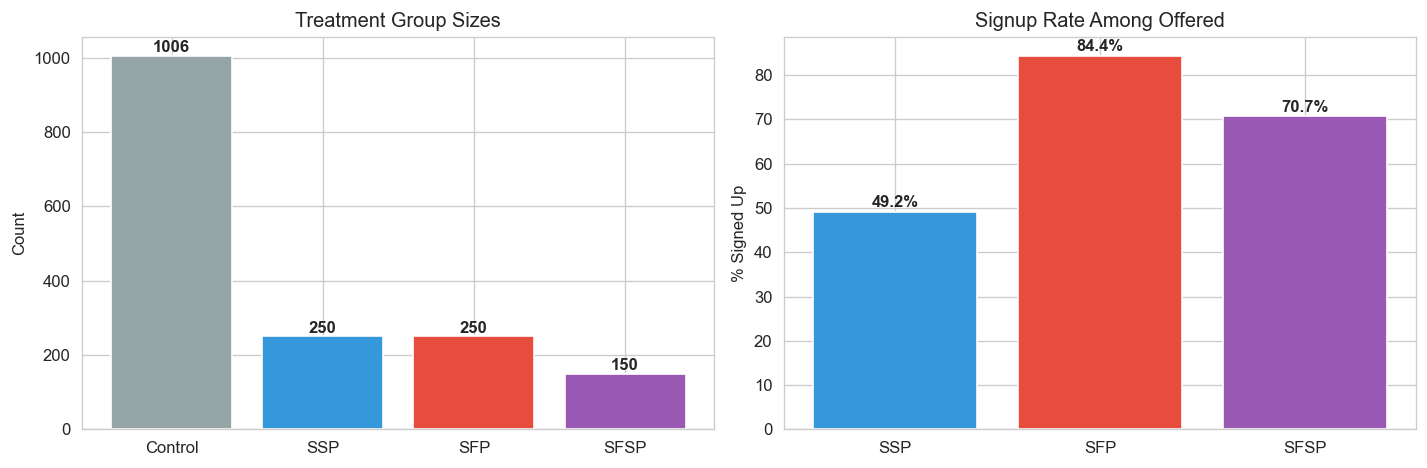

In [3]:
# Create a treatment group variable
def assign_group(row):
    if row["sfsp"] == 1:
        return "SFSP"
    elif row["sfp"] == 1:
        return "SFP"
    elif row["ssp"] == 1:
        return "SSP"
    else:
        return "Control"

df["treatment"] = df.apply(assign_group, axis=1)

group_counts = df["treatment"].value_counts().reindex(["Control", "SSP", "SFP", "SFSP"])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ["#95a5a6", "#3498db", "#e74c3c", "#9b59b6"]
axes[0].bar(group_counts.index, group_counts.values, color=colors)
axes[0].set_ylabel("Count")
axes[0].set_title("Treatment Group Sizes")
for i, v in enumerate(group_counts.values):
    axes[0].text(i, v + 10, str(v), ha="center", fontweight="bold")

# Signup rates among treated
treated = df[df["control"] == 0]
signup_rates = treated.groupby("treatment")["signup"].mean().reindex(["SSP", "SFP", "SFSP"])
axes[1].bar(signup_rates.index, signup_rates.values * 100, color=colors[1:])
axes[1].set_ylabel("% Signed Up")
axes[1].set_title("Signup Rate Among Offered")
for i, v in enumerate(signup_rates.values):
    axes[1].text(i, v * 100 + 1, f"{v*100:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
fig.savefig("figures/eda/treatment_groups.png", dpi=150, bbox_inches="tight")
plt.show()

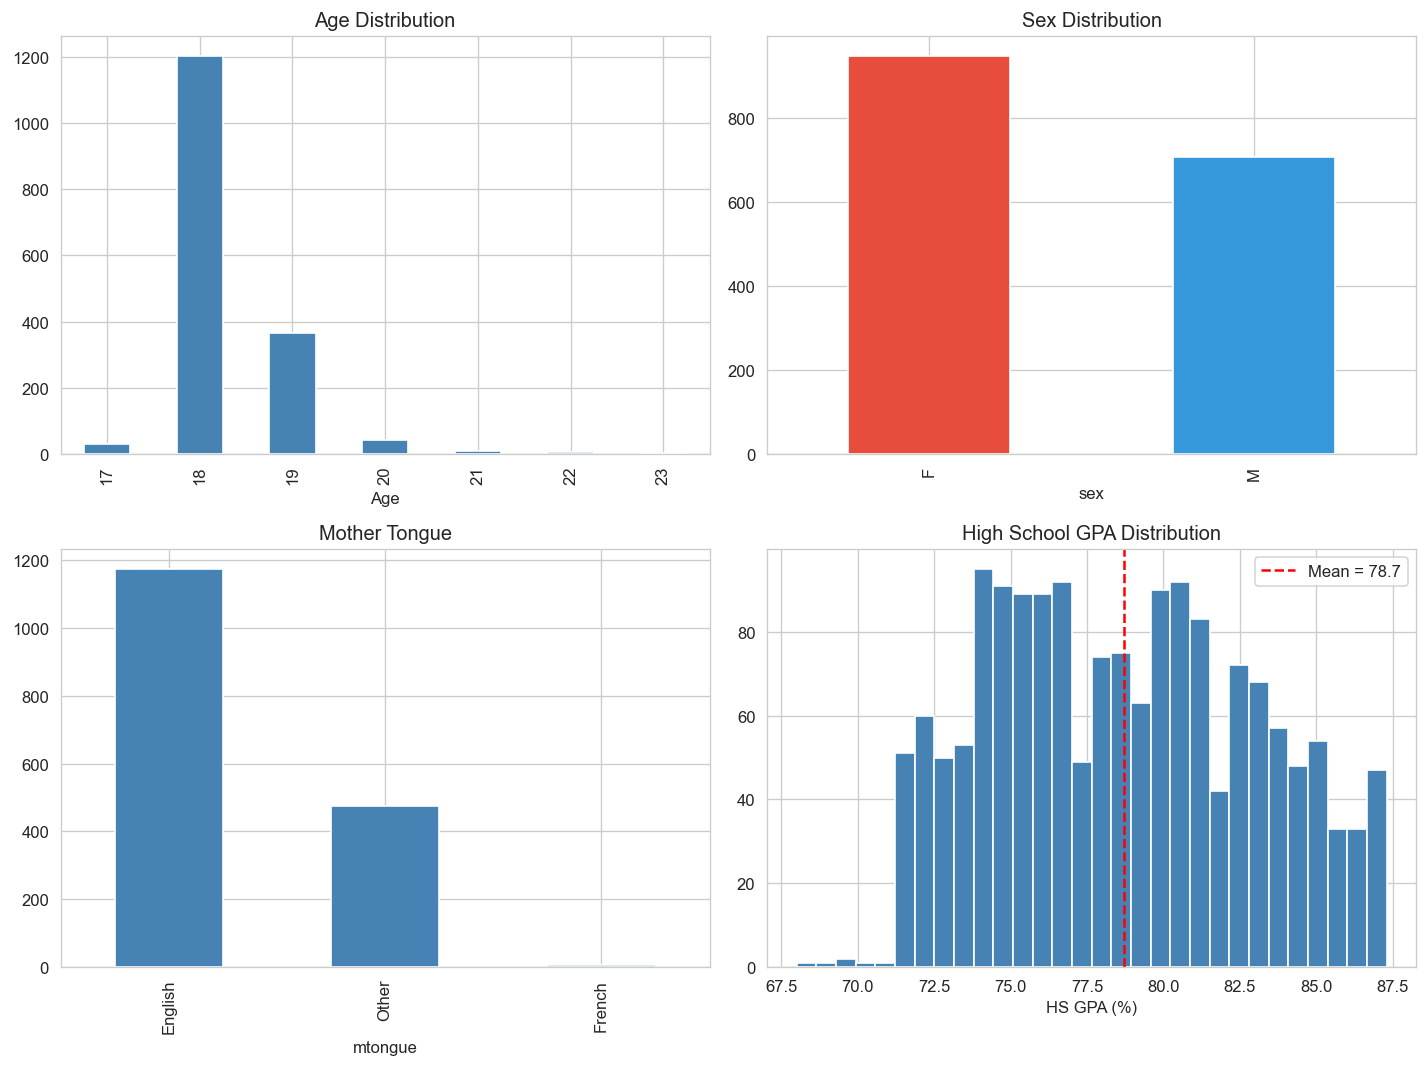

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Age distribution
df["age"].value_counts().sort_index().plot.bar(ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Age Distribution")
axes[0, 0].set_xlabel("Age")

# Sex
df["sex"].value_counts().plot.bar(ax=axes[0, 1], color=["#e74c3c", "#3498db"])
axes[0, 1].set_title("Sex Distribution")

# Mother tongue
df["mtongue"].value_counts().plot.bar(ax=axes[1, 0], color="steelblue")
axes[1, 0].set_title("Mother Tongue")

# High school GPA
axes[1, 1].hist(df["gpa0"], bins=30, color="steelblue", edgecolor="white")
axes[1, 1].axvline(df["gpa0"].mean(), color="red", linestyle="--", label=f'Mean = {df["gpa0"].mean():.1f}')
axes[1, 1].set_title("High School GPA Distribution")
axes[1, 1].set_xlabel("HS GPA (%)")
axes[1, 1].legend()

plt.tight_layout()
fig.savefig("figures/eda/demographics.png", dpi=150, bbox_inches="tight")
plt.show()

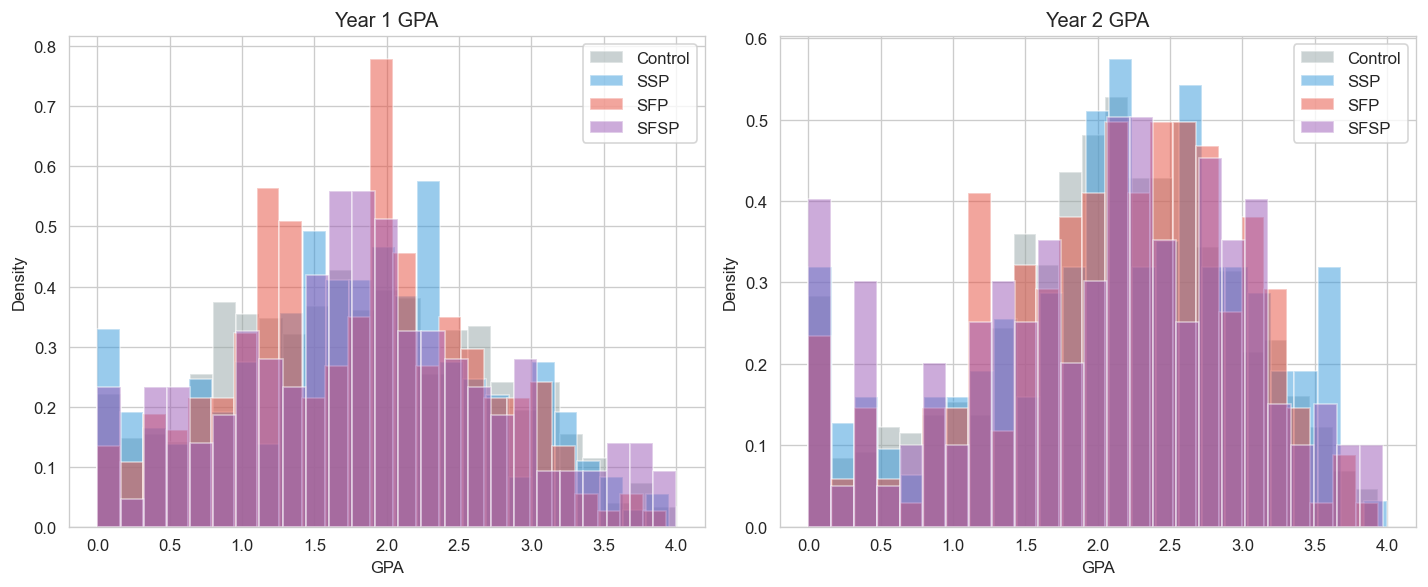

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col, title in zip(axes, ["GPA_year1", "GPA_year2"], ["Year 1 GPA", "Year 2 GPA"]):
    for grp, color in zip(["Control", "SSP", "SFP", "SFSP"], colors):
        subset = df[df["treatment"] == grp][col].dropna()
        ax.hist(subset, bins=25, alpha=0.5, label=grp, color=color, density=True)
    ax.set_title(title)
    ax.set_xlabel("GPA")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
fig.savefig("figures/eda/gpa_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

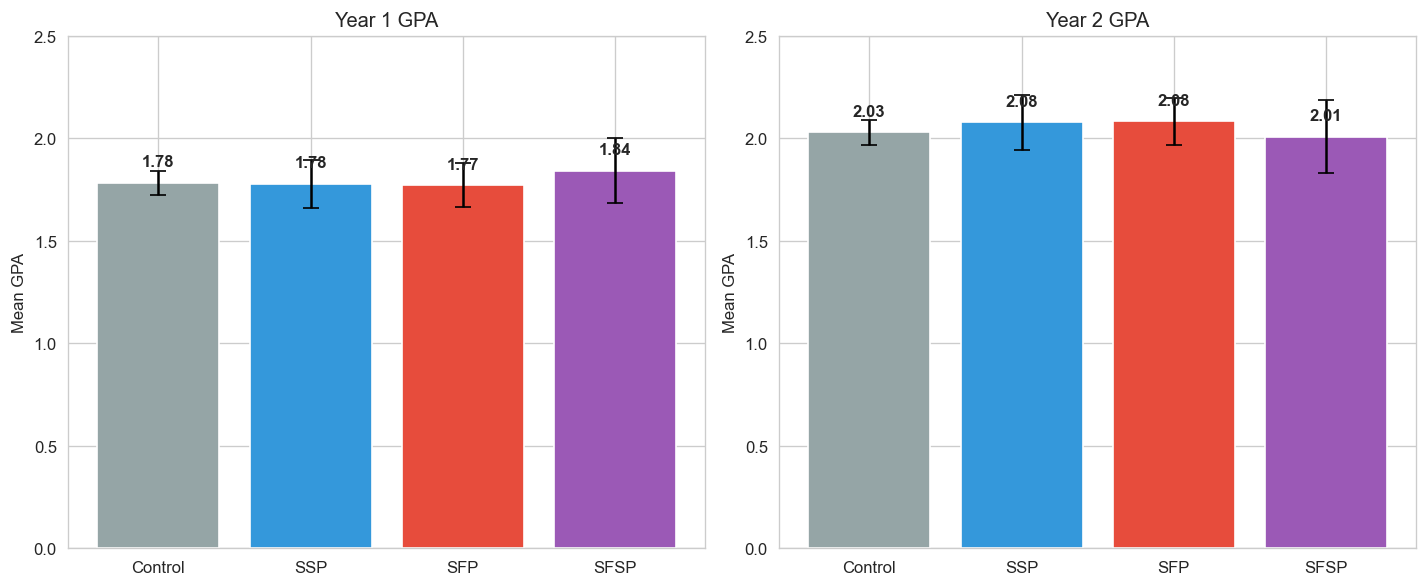

In [6]:
# Mean GPA by treatment group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col, title in zip(axes, ["GPA_year1", "GPA_year2"], ["Year 1 GPA", "Year 2 GPA"]):
    means = df.groupby("treatment")[col].mean().reindex(["Control", "SSP", "SFP", "SFSP"])
    sems = df.groupby("treatment")[col].sem().reindex(["Control", "SSP", "SFP", "SFSP"])
    bars = ax.bar(means.index, means.values, yerr=1.96 * sems.values,
                  color=colors, capsize=5)
    ax.set_title(title)
    ax.set_ylabel("Mean GPA")
    ax.set_ylim(0, 2.5)
    for bar, m in zip(bars, means.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.08,
                f"{m:.2f}", ha="center", fontweight="bold")

plt.tight_layout()
fig.savefig("figures/eda/mean_gpa.png", dpi=150, bbox_inches="tight")
plt.show()

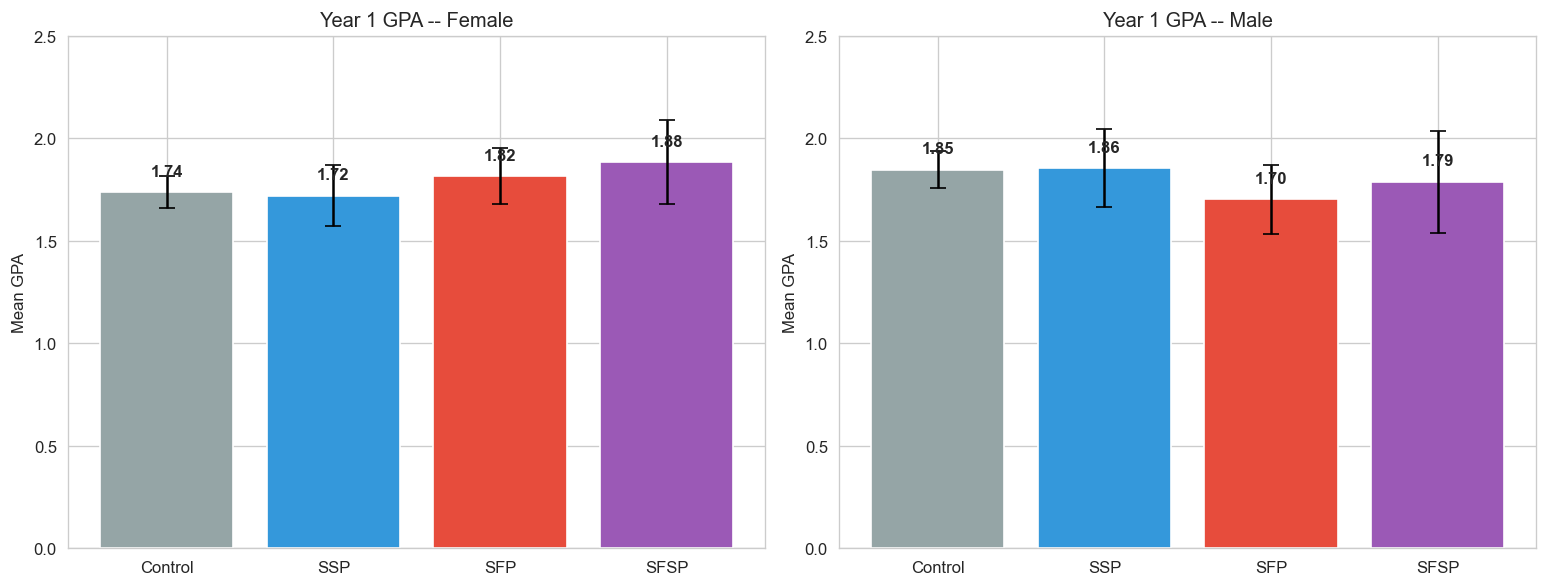

In [7]:
# GPA Year 1 by treatment and sex
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, sex_val, title in zip(axes, ["F", "M"], ["Female", "Male"]):
    sub = df[df["sex"] == sex_val]
    means = sub.groupby("treatment")["GPA_year1"].mean().reindex(["Control", "SSP", "SFP", "SFSP"])
    sems = sub.groupby("treatment")["GPA_year1"].sem().reindex(["Control", "SSP", "SFP", "SFSP"])
    bars = ax.bar(means.index, means.values, yerr=1.96 * sems.values,
                  color=colors, capsize=5)
    ax.set_title(f"Year 1 GPA -- {title}")
    ax.set_ylabel("Mean GPA")
    ax.set_ylim(0, 2.5)
    for bar, m in zip(bars, means.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.08,
                f"{m:.2f}", ha="center", fontweight="bold")

plt.tight_layout()
fig.savefig("figures/eda/gpa_by_sex.png", dpi=150, bbox_inches="tight")
plt.show()

In [8]:
# STAR dataset for analysis: use same structure as analysis_gender_v2 (treat, female)
star = df.copy()
if "female" not in star.columns:
    star["female"] = (star["sex"] == "F").astype(int)

# Treatment group labels (analysis_gender_v2 uses 'treat' with Control, SFP, SSP, SFSP)
star["treat"] = "Control"
star.loc[star["sfp"] == 1, "treat"] = "SFP"
star.loc[star["ssp"] == 1, "treat"] = "SSP"
star.loc[star["sfsp"] == 1, "treat"] = "SFSP"

# Any SFP or SFSP (for regression specs)
if "sfpany" not in star.columns:
    star["sfpany"] = ((star["sfp"] == 1) | (star["sfsp"] == 1)).astype(int)

# Ability group labels (hsgroup: 1=low, 2=mid, 3=high HS GPA)
star["ability"] = star["hsgroup"].map({1: "Low", 2: "Mid", 3: "High"})

print('='*70)
print('STAR SAMPLE DESCRIPTION')
print('='*70)

# Sample sizes by treatment x gender
print('\nSample size by treatment x gender:')
ct = pd.crosstab(star['treat'], star['female'].map({0: 'Male', 1: 'Female'}), margins=True)
print(ct)

# Balance check: baseline characteristics by treatment
print('\n--- Baseline balance (means by treatment group) ---')
balance_vars = ['female', 'age', 'gpa0', 'english', 'mom2', 'dad2', 'hcom']
balance = star.groupby('treat')[balance_vars].mean()
print(balance.round(3))

# F-test for joint balance
print('\n--- Balance F-tests (each var ~ treatment dummies) ---')
for v in balance_vars:
    sub = star.dropna(subset=[v])
    groups = [sub.loc[sub['treat'] == t, v].values for t in ['Control', 'SFP', 'SSP', 'SFSP']]
    f, p = stats.f_oneway(*groups)
    sig = '*' if p < 0.1 else ''
    print(f'  {v:12s}: F={f:.3f}, p={p:.3f} {sig}')

STAR SAMPLE DESCRIPTION

Sample size by treatment x gender:
female   Female  Male   All
treat                      
Control     574   432  1006
SFP         150   100   250
SFSP         82    68   150
SSP         142   108   250
All         948   708  1656

--- Baseline balance (means by treatment group) ---
         female     age       gpa0  english   mom2   dad2   hcom
treat                                                           
Control   0.571  18.292  78.671997    0.701  0.363  0.454  0.805
SFP       0.600  18.272  78.820000    0.708  0.338  0.450  0.820
SFSP      0.547  18.333  78.474998    0.747  0.307  0.417  0.811
SSP       0.568  18.280  78.847000    0.720  0.414  0.473  0.768

--- Balance F-tests (each var ~ treatment dummies) ---
  female      : F=0.405, p=0.749 
  age         : F=0.328, p=0.805 
  gpa0        : F=0.319, p=0.812 
  english     : F=0.502, p=0.681 
  mom2        : F=1.589, p=0.190 
  dad2        : F=0.335, p=0.800 
  hcom        : F=0.716, p=0.543 


In [9]:
# Gender gap in outcomes by treatment
outcomes_star = {
    'GPA_year1': 'GPA (Year 1)',
    'GPA_year2': 'GPA (Year 2)',
    'credits_earned1': 'Credits (Y1)',
    'credits_earned2': 'Credits (Y2)',
}

print('='*70)
print('GENDER GAP (Female - Male) BY TREATMENT GROUP')
print('='*70)

gap_rows = []
for var, label in outcomes_star.items():
    for treat in ['Control', 'SFP', 'SSP', 'SFSP']:
        sub = star[star['treat'] == treat]
        m = sub.loc[sub['female'] == 0, var].dropna()
        f = sub.loc[sub['female'] == 1, var].dropna()
        gap = f.mean() - m.mean()
        _, pval = stats.ttest_ind(m, f)
        gap_rows.append({'outcome': label, 'treatment': treat,
                         'male_mean': m.mean(), 'female_mean': f.mean(),
                         'gap (F-M)': gap, 'p_value': pval})

gap_df = pd.DataFrame(gap_rows)

# Pivot for display
for var, label in outcomes_star.items():
    sub = gap_df[gap_df['outcome'] == outcomes_star[var]]
    print(f'\n  {label}:')
    for _, r in sub.iterrows():
        sig = '*' if r['p_value'] < 0.1 else ''
        print(f'    {r["treatment"]:8s}: Male={r["male_mean"]:.3f}  Female={r["female_mean"]:.3f}  '
              f'Gap={r["gap (F-M)"]:+.3f}  (p={r["p_value"]:.3f}) {sig}')

GENDER GAP (Female - Male) BY TREATMENT GROUP

  GPA (Year 1):
    Control : Male=1.847  Female=1.739  Gap=-0.108  (p=0.075) *
    SFP     : Male=1.702  Female=1.817  Gap=+0.114  (p=0.303) 
    SSP     : Male=1.856  Female=1.721  Gap=-0.135  (p=0.268) 
    SFSP    : Male=1.789  Female=1.884  Gap=+0.095  (p=0.562) 

  GPA (Year 2):
    Control : Male=2.047  Female=2.017  Gap=-0.030  (p=0.627) 
    SFP     : Male=2.001  Female=2.142  Gap=+0.141  (p=0.237) 
    SSP     : Male=2.073  Female=2.083  Gap=+0.010  (p=0.941) 
    SFSP    : Male=1.741  Female=2.225  Gap=+0.484  (p=0.007) *

  Credits (Y1):
    Control : Male=2.429  Female=2.303  Gap=-0.126  (p=0.055) *
    SFP     : Male=2.206  Female=2.406  Gap=+0.200  (p=0.092) *
    SSP     : Male=2.358  Female=2.393  Gap=+0.035  (p=0.802) 
    SFSP    : Male=2.160  Female=2.487  Gap=+0.327  (p=0.049) *

  Credits (Y2):
    Control : Male=2.374  Female=2.496  Gap=+0.123  (p=0.215) 
    SFP     : Male=2.482  Female=2.536  Gap=+0.054  (p=0.768) 

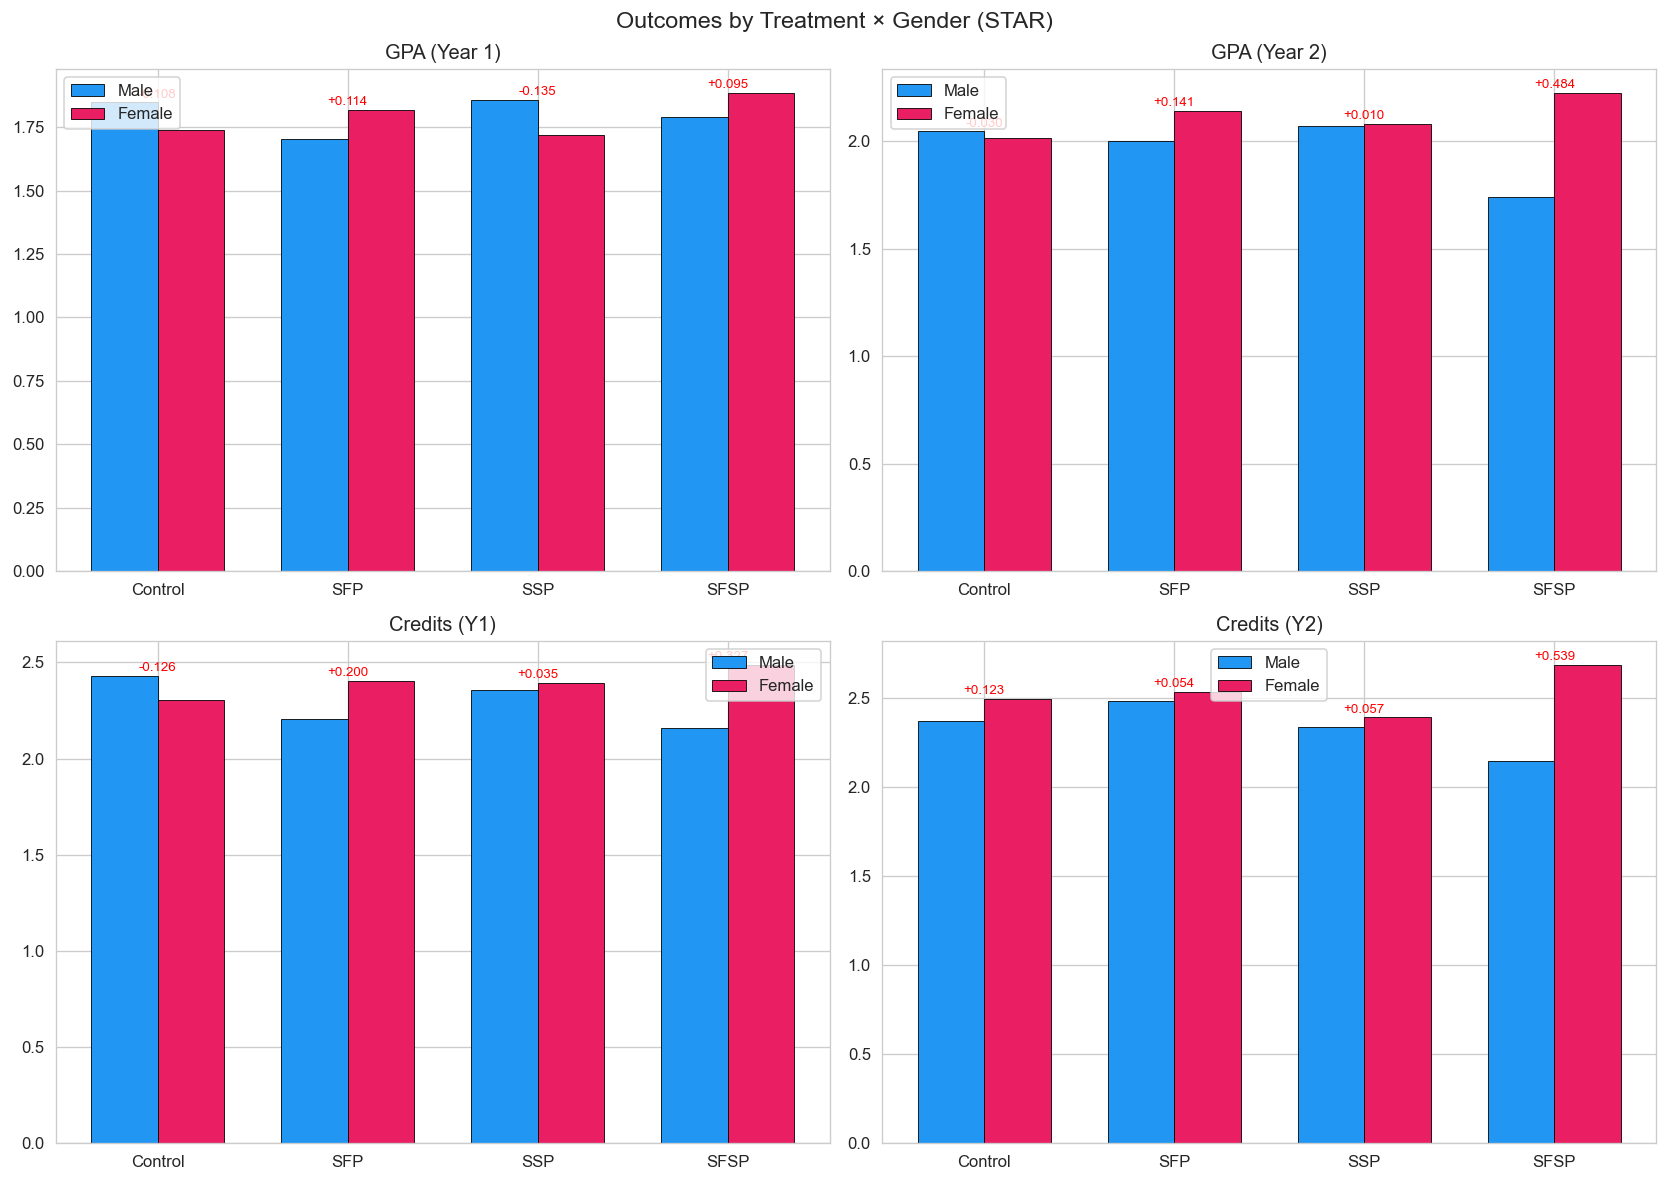

In [10]:
# Visualise: gender gap by treatment for key outcomes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (var, label) in zip(axes.flat, [('GPA_year1', 'GPA (Year 1)'), ('GPA_year2', 'GPA (Year 2)'),
                                          ('credits_earned1', 'Credits (Y1)'), ('credits_earned2', 'Credits (Y2)')]):
    treats = ['Control', 'SFP', 'SSP', 'SFSP']
    male_means = [star[(star['treat']==t) & (star['female']==0)][var].mean() for t in treats]
    female_means = [star[(star['treat']==t) & (star['female']==1)][var].mean() for t in treats]

    x = np.arange(4)
    w = 0.35
    ax.bar(x - w/2, male_means, w, label='Male', color='#2196F3', edgecolor='black', linewidth=0.5)
    ax.bar(x + w/2, female_means, w, label='Female', color='#E91E63', edgecolor='black', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(treats)
    ax.set_title(label)
    ax.legend()

    # Annotate gaps
    for i, (m, f) in enumerate(zip(male_means, female_means)):
        gap = f - m
        y = max(m, f) + 0.01 * abs(max(male_means + female_means))
        ax.text(i, y, f'{gap:+.3f}', ha='center', fontsize=8, color='red')

fig.suptitle('Outcomes by Treatment × Gender (STAR)', fontsize=14)
plt.tight_layout()
fig.savefig('figures/star_outcomes_by_treatment_gender.png', bbox_inches='tight', dpi=150)
plt.show()

In [11]:
# ── Subgroup outcome tables: Treatment × Gender ──
star['gender'] = star['female'].map({0: 'Male', 1: 'Female'})

all_outcomes = [('GPA_year1', 'GPA — Year 1'), ('GPA_year2', 'GPA — Year 2'),
                ('credits_earned1', 'Credits Earned — Year 1'),
                ('credits_earned2', 'Credits Earned — Year 2')]

for outcome, label in all_outcomes:
    print('='*80)
    print(f'  {label}')
    print('='*80)

    rows = []
    for treat in ['Control', 'SFP', 'SSP', 'SFSP']:
        for gender in ['Male', 'Female']:
            sub = star[(star['treat'] == treat) & (star['gender'] == gender)][outcome].dropna()
            rows.append({
                'Treatment': treat, 'Gender': gender,
                'Mean': sub.mean() if len(sub) else np.nan,
                'SD': sub.std() if len(sub) else np.nan,
                'N': len(sub),
            })

    tbl = pd.DataFrame(rows)
    tbl['cell'] = tbl.apply(
        lambda r: f"{r['Mean']:.3f} ({r['SD']:.3f}) [n={r['N']}]" if r['N'] > 0 else '—', axis=1
    )
    wide = tbl.pivot_table(index='Treatment', columns='Gender', values='cell', aggfunc='first')
    wide = wide[['Male', 'Female']]

    # Gender gap
    mean_tbl = tbl.pivot_table(index='Treatment', columns='Gender', values='Mean', aggfunc='first')
    wide['Gap (F−M)'] = (mean_tbl['Female'] - mean_tbl['Male']).map(lambda x: f'{x:+.3f}' if pd.notna(x) else '—')

    wide = wide.reindex(['Control', 'SFP', 'SSP', 'SFSP'])
    print(wide.to_string())
    print()

  GPA — Year 1
Gender                      Male                 Female Gap (F−M)
Treatment                                                        
Control    1.847 (0.912) [n=395]  1.739 (0.919) [n=540]    -0.108
SFP         1.702 (0.814) [n=92]  1.817 (0.842) [n=145]    +0.114
SSP         1.856 (0.968) [n=99]  1.721 (0.879) [n=132]    -0.135
SFSP        1.789 (0.976) [n=59]   1.884 (0.911) [n=75]    +0.095

  GPA — Year 2
Gender                      Male                 Female Gap (F−M)
Treatment                                                        
Control    2.047 (0.918) [n=355]  2.017 (0.869) [n=475]    -0.030
SFP         2.001 (0.888) [n=91]  2.142 (0.851) [n=126]    +0.141
SSP         2.073 (1.021) [n=87]  2.083 (0.921) [n=109]    +0.010
SFSP        1.741 (1.145) [n=56]   2.225 (0.831) [n=69]    +0.484

  Credits Earned — Year 1
Gender                      Male                 Female Gap (F−M)
Treatment                                                        
Control    2.429 (

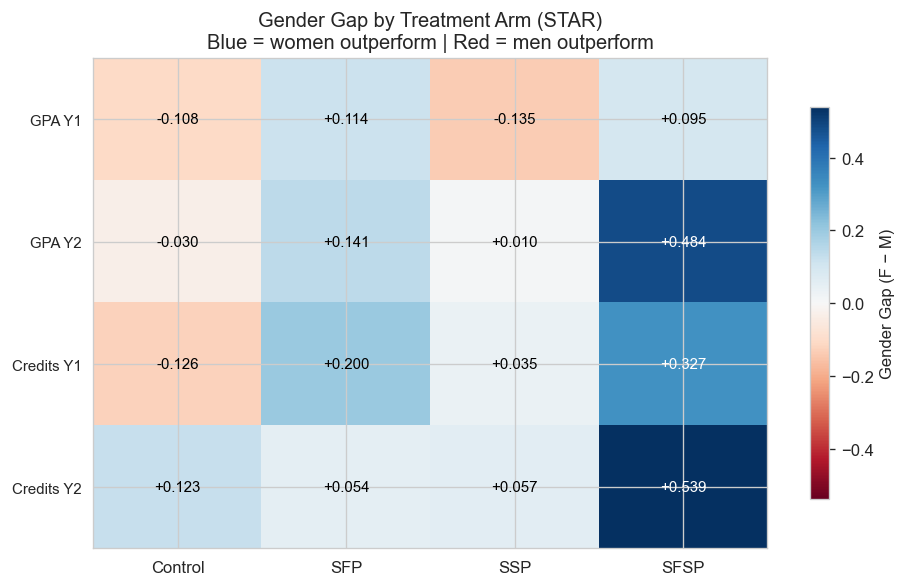

In [12]:
# Heatmap: Gender gap (F−M) across Treatment arms for all outcomes
outcomes_heat = [('GPA_year1', 'GPA Y1'), ('GPA_year2', 'GPA Y2'),
                 ('credits_earned1', 'Credits Y1'), ('credits_earned2', 'Credits Y2')]

heat_rows = []
for outcome, label in outcomes_heat:
    for treat in ['Control', 'SFP', 'SSP', 'SFSP']:
        m = star[(star['treat'] == treat) & (star['female'] == 0)][outcome].dropna()
        f = star[(star['treat'] == treat) & (star['female'] == 1)][outcome].dropna()
        gap = f.mean() - m.mean() if len(m) > 0 and len(f) > 0 else np.nan
        heat_rows.append({'Outcome': label, 'Treatment': treat, 'gap': gap})

heat_df = pd.DataFrame(heat_rows)
pivot = heat_df.pivot(index='Outcome', columns='Treatment', values='gap')
pivot = pivot[['Control', 'SFP', 'SSP', 'SFSP']]
row_order = [label for _, label in outcomes_heat]
pivot = pivot.reindex(row_order)

fig, ax = plt.subplots(figsize=(8, 5))
import matplotlib.colors as mcolors
vabs = max(abs(np.nanmin(pivot.values)), abs(np.nanmax(pivot.values)), 0.01)
norm = mcolors.TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)
im = ax.imshow(pivot.values, cmap='RdBu', norm=norm, aspect='auto')

ax.set_xticks(range(pivot.shape[1]))
ax.set_xticklabels(pivot.columns, fontsize=10)
ax.set_yticks(range(pivot.shape[0]))
ax.set_yticklabels(pivot.index, fontsize=9)

for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        v = pivot.values[i, j]
        if not np.isnan(v):
            ax.text(j, i, f'{v:+.3f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(v) > vabs * 0.6 else 'black')

plt.colorbar(im, ax=ax, label='Gender Gap (F − M)', shrink=0.8)
ax.set_title('Gender Gap by Treatment Arm (STAR)\nBlue = women outperform | Red = men outperform', fontsize=12)
plt.tight_layout()
fig.savefig('figures/star_gender_gap_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()

In [13]:
# Main interaction regressions: Treatment × Female
controls = 'gpa0 + age + english + mom2'
reg_outcomes = ['GPA_year1', 'GPA_year2', 'credits_earned1', 'credits_earned2']

print('='*80)
print('TREATMENT × FEMALE INTERACTIONS (STAR RCT)')
print('='*80)

all_results = []
for treat_var, treat_label in [('sfp', 'SFP (Financial)'), ('ssp', 'SSP (Academic)'),
                                 ('sfsp', 'SFSP (Both)'), ('sfpany', 'Any SFP/SFSP')]:
    print(f'\n{"─"*80}')
    print(f'  {treat_label} ({treat_var})')
    print(f'{"─"*80}')

    for dep in reg_outcomes:
        sub = star.dropna(subset=[dep, treat_var, 'female', 'gpa0', 'age', 'english', 'mom2']).copy()
        formula = f'{dep} ~ {treat_var} * female + {controls}'
        m = smf.ols(formula, data=sub).fit(cov_type='HC1')

        # Find interaction key
        int_key = [k for k in m.params.index if treat_var in k and 'female' in k]
        if int_key:
            k = int_key[0]
            coef = m.params[k]
            se = m.bse[k]
            p = m.pvalues[k]
            star_sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''

            # Treatment effect by gender
            treat_male = m.params[treat_var]
            treat_female = m.params[treat_var] + coef

            print(f'  {dep:22s}: β(treat×female)={coef:+.4f} (SE={se:.4f}, p={p:.3f}) {star_sig}')
            print(f'    {"":22s}  Effect on males: {treat_male:+.4f}  |  Effect on females: {treat_female:+.4f}')

            all_results.append({
                'treatment': treat_label, 'outcome': dep,
                'interaction': coef, 'se': se, 'p': p,
                'effect_male': treat_male, 'effect_female': treat_female,
                'n': len(sub)
            })

results_df = pd.DataFrame(all_results)

TREATMENT × FEMALE INTERACTIONS (STAR RCT)

────────────────────────────────────────────────────────────────────────────────
  SFP (Financial) (sfp)
────────────────────────────────────────────────────────────────────────────────
  GPA_year1             : β(treat×female)=+0.1442 (SE=0.1186, p=0.224) 
                            Effect on males: -0.1570  |  Effect on females: -0.0128
  GPA_year2             : β(treat×female)=+0.0532 (SE=0.1304, p=0.683) 
                            Effect on males: -0.0654  |  Effect on females: -0.0122
  credits_earned1       : β(treat×female)=+0.1642 (SE=0.1279, p=0.199) 
                            Effect on males: -0.1484  |  Effect on females: +0.0158
  credits_earned2       : β(treat×female)=-0.2567 (SE=0.2067, p=0.214) 
                            Effect on males: +0.1845  |  Effect on females: -0.0722

────────────────────────────────────────────────────────────────────────────────
  SSP (Academic) (ssp)
─────────────────────────────────────────

In [14]:
# DiD from raw subgroup means: DiD = (Y_F^T - Y_M^T) - (Y_F^C - Y_M^C)
# Compare to regression interaction coefficient (should match when no controls, or approximate with controls)
reg_outcomes = ['GPA_year1', 'GPA_year2', 'credits_earned1', 'credits_earned2']
treat_specs = [('sfp', 'SFP (Financial)'), ('ssp', 'SSP (Academic)'),
               ('sfsp', 'SFSP (Both)'), ('sfpany', 'Any SFP/SFSP')]

did_rows = []
for treat_var, treat_label in treat_specs:
    if treat_var == 'sfpany':
        treated = (star['sfp'] == 1) | (star['sfsp'] == 1)
    else:
        treated = star[treat_var] == 1
    control = star['treat'] == 'Control'

    for outcome in reg_outcomes:
        sub = star.dropna(subset=[outcome, treat_var if treat_var != 'sfpany' else 'sfp', 'female'])
        if treat_var == 'sfpany':
            sub_treated = (sub['sfp'] == 1) | (sub['sfsp'] == 1)
        else:
            sub_treated = sub[treat_var] == 1
        sub_control = sub['treat'] == 'Control'

        Y_F_C = sub.loc[sub_control & (sub['female'] == 1), outcome].mean()
        Y_M_C = sub.loc[sub_control & (sub['female'] == 0), outcome].mean()
        Y_F_T = sub.loc[sub_treated & (sub['female'] == 1), outcome].mean()
        Y_M_T = sub.loc[sub_treated & (sub['female'] == 0), outcome].mean()

        did_raw = (Y_F_T - Y_M_T) - (Y_F_C - Y_M_C)
        reg_row = results_df[(results_df['treatment'] == treat_label) & (results_df['outcome'] == outcome)]
        reg_coef = reg_row['interaction'].values[0] if len(reg_row) else np.nan
        did_rows.append({
            'treatment': treat_label, 'outcome': outcome,
            'Y_F_T': Y_F_T, 'Y_M_T': Y_M_T, 'Y_F_C': Y_F_C, 'Y_M_C': Y_M_C,
            'DiD_raw': did_raw, 'regression_interaction': reg_coef,
            'diff': did_raw - reg_coef if not np.isnan(reg_coef) else np.nan
        })

did_df = pd.DataFrame(did_rows)
print('='*80)
print('DiD FROM RAW MEANS vs REGRESSION INTERACTION')
print('DiD = (Y_F^T - Y_M^T) - (Y_F^C - Y_M^C)')
print('='*80)
for treat_label in [t[1] for t in treat_specs]:
    sub = did_df[did_df['treatment'] == treat_label]
    print(f'\n{treat_label}:')
    print(sub[['outcome', 'DiD_raw', 'regression_interaction', 'diff']].to_string(index=False))
print('\n(Diff = DiD_raw - regression; small diff expected when regression includes controls.)')

DiD FROM RAW MEANS vs REGRESSION INTERACTION
DiD = (Y_F^T - Y_M^T) - (Y_F^C - Y_M^C)

SFP (Financial):
        outcome   DiD_raw  regression_interaction     diff
      GPA_year1  0.222446                0.144206 0.078240
      GPA_year2  0.171812                0.053204 0.118608
credits_earned1  0.326178                0.164178 0.162000
credits_earned2 -0.068376               -0.256677 0.188301

SSP (Academic):
        outcome   DiD_raw  regression_interaction      diff
      GPA_year1 -0.027390               -0.025030 -0.002360
      GPA_year2  0.040612                0.066094 -0.025482
credits_earned1  0.160835                0.146725  0.014110
credits_earned2 -0.065755                0.141682 -0.207437

SFSP (Both):
        outcome  DiD_raw  regression_interaction      diff
      GPA_year1 0.203056                0.206166 -0.003110
      GPA_year2 0.514356                0.453463  0.060893
credits_earned1 0.452916                0.387641  0.065275
credits_earned2 0.416562           

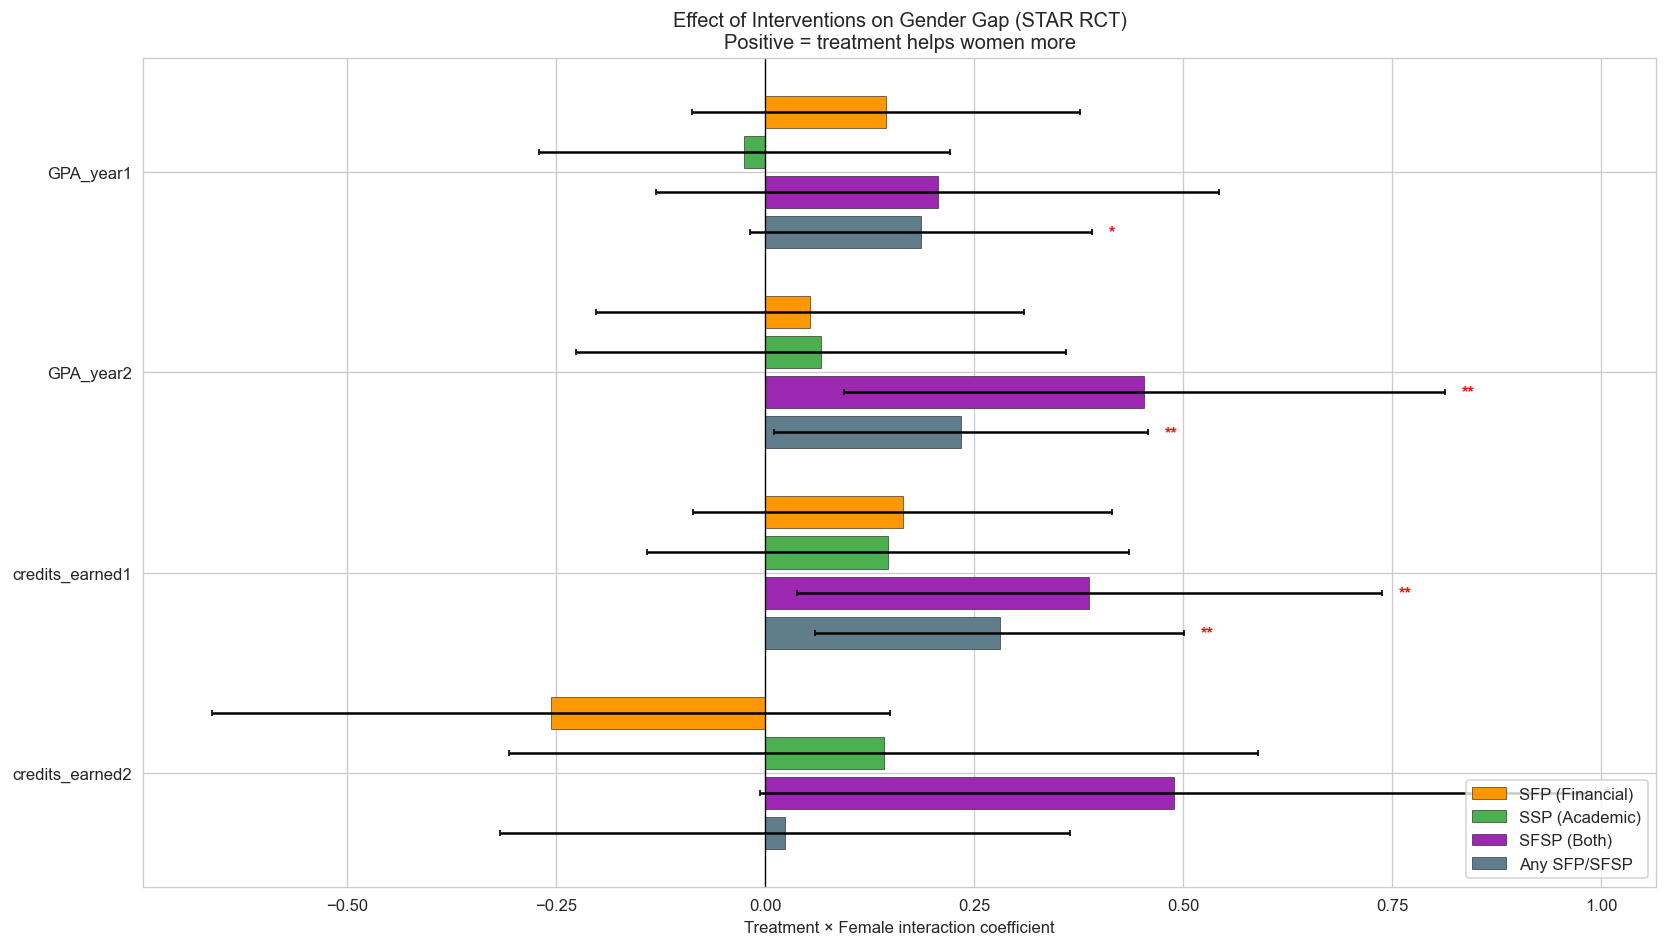

In [15]:
# Summary visualisation: interaction coefficients across all treatment × outcome pairs
fig, ax = plt.subplots(figsize=(14, 8))

for i, (treat_label, color) in enumerate([('SFP (Financial)', '#FF9800'), ('SSP (Academic)', '#4CAF50'),
                                           ('SFSP (Both)', '#9C27B0'), ('Any SFP/SFSP', '#607D8B')]):
    sub = results_df[results_df['treatment'] == treat_label]
    y_pos = np.arange(len(sub)) * 5 + i
    ax.barh(y_pos, sub['interaction'], xerr=1.96 * sub['se'], color=color,
            label=treat_label, height=0.8, edgecolor='black', linewidth=0.3, capsize=2)

    for j, (_, row) in enumerate(sub.iterrows()):
        sig = '***' if row['p'] < 0.01 else '**' if row['p'] < 0.05 else '*' if row['p'] < 0.1 else ''
        if sig:
            ax.text(row['interaction'] + 1.96 * row['se'] + 0.02, y_pos[j], sig,
                    va='center', fontsize=10, color='red', fontweight='bold')

ax.axvline(0, color='black', linewidth=0.8)
ax.set_yticks(np.arange(len(reg_outcomes)) * 5 + 1.5)
ax.set_yticklabels(reg_outcomes)
ax.set_xlabel('Treatment × Female interaction coefficient')
ax.set_title('Effect of Interventions on Gender Gap (STAR RCT)\nPositive = treatment helps women more')
ax.legend(loc='lower right')
ax.invert_yaxis()
plt.tight_layout()
fig.savefig('figures/star_interaction_coefficients.png', bbox_inches='tight', dpi=150)
plt.show()